### 手动实现线性回归 

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w)+b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:',features[0],'\nlabels:', labels[0])

features: tensor([0.8068, 0.2531]) 
labels: tensor([4.9606])


In [10]:
d2l.set_figsize()

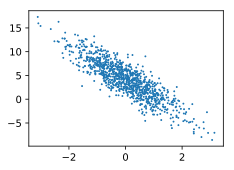

In [11]:
d2l.plt.scatter(features[:, 1].detach().numpy(),
               labels.detach().numpy(), 1)

#### 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [13]:
batch_size = 10

In [14]:
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0626, -1.3819],
        [ 1.3002, -1.6405],
        [-0.2143,  0.1157],
        [ 0.3747,  0.1398],
        [ 0.7321,  0.7536],
        [-1.0199,  1.0867],
        [-1.1761,  1.0229],
        [ 1.0091,  0.3677],
        [-0.3801, -0.5643],
        [-0.7545,  1.8007]]) 
 tensor([[11.0434],
        [12.3610],
        [ 3.3817],
        [ 4.4807],
        [ 3.1153],
        [-1.5422],
        [-1.6426],
        [ 4.9857],
        [ 5.3447],
        [-3.4343]])


#### 定义 初始化模型参数

In [15]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad = True)

#### 定义模型

In [16]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w)+b

#### 定义损失函数
在损失函数中并没有取均值，即没有除以batch_size,而是在优化算法中做了，二者等价

In [18]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

#### 定义随机梯度下降(stochastic gradient descent)优化算法

In [19]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

#### 训练过程

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为l形状是(`batch_size`, 1), 而不是一个标量。`l` 中的所有元素被累加到一起
        # 并以此计算关于[`w`,`b`]的梯度
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.042440
epoch 2, loss 0.000161
epoch 3, loss 0.000047


In [22]:
print(f'w的估计误差： {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差： {true_b - b}')

w的估计误差： tensor([-0.0002, -0.0006], grad_fn=<SubBackward0>)
b的估计误差： tensor([0.0012], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现 

In [23]:
import numpy as np
from torch.utils import data

In [25]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 100)

#### 调用框架中现有的API来读取数据

In [26]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [32]:
next(iter(data_iter))

[tensor([[ 0.5283,  0.2948],
         [-0.8903, -0.3965],
         [-1.5611, -1.0055],
         [ 1.1645,  0.5376],
         [ 2.0624, -0.3454],
         [ 0.1723, -1.8691],
         [-0.2568, -1.4501],
         [ 0.0065, -0.4836],
         [-1.1152, -0.6035],
         [ 0.4217, -0.7177]]),
 tensor([[ 4.2522],
         [ 3.7881],
         [ 4.5270],
         [ 4.6987],
         [ 9.5021],
         [10.9073],
         [ 8.6155],
         [ 5.8502],
         [ 4.0087],
         [ 7.4830]])]

#### 使用框架预定义好的层

In [33]:
# `nn`是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

#### 初始化模型参数

In [35]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

#### 计算均方误差使用的是MSELoss类，也成为平方L2范数

In [36]:
loss = nn.MSELoss()

#### 实例化SGD实例

In [38]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

#### 训练过程代码与从零开始实现时所做的非常相似

In [39]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()  # 为什么不是在trainer.step()语句之后？
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 9.681911
epoch 2, loss 3.371778
epoch 3, loss 1.197687


### 问答

#### 为什么使用平方损失而不用绝对差值（L1范数）？

    其实二者没太大区别，都可以。最初没有使用绝对差值，是因为在值为0处不容易求导。

#### 损失为什么要求平均？

    不求平均也可以，但是学习率会根据batch的大小而变化(因为此时相当于扩大了梯度，
    而缩小了学习率)，不容易调超参数。为了解耦，需要求平均。

#### backward()这里是调用PyTorch自定义的back propogation吗？

    是的

#### 每个batch计算的时候，为什么需要把梯度先清零呀？

    因为Pytorch不帮我们自动清零，如果不清零的话，会在原有的梯度上自动累加。